## Outlier detection

Identifying fradulent transactions in credit card transactions. 
the dataset is downloaded from kaggle https://www.kaggle.com/mlg-ulb/creditcardfraud/data

Intention of the notebook is to use one of the classification algorithm on skewed dataset and later undersample the data to build the model. Apply the model that was built on undersample data to whole dataset.

Use a different classifier (SGD) and see any improvements in ROC parameter

Use the scikit in-built outlier detection http://scikit-learn.org/stable/modules/outlier_detection.html


Import the necessary python libraries and load the dataset

In [1]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, SGDClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, roc_curve, roc_auc_score, auc, fbeta_score, precision_score 
%matplotlib inline

df = pd.read_csv('creditcard.csv');
print(df.shape)
df.head(10)

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


Observing the data-frame implies there exists 31 features for the data, out of which 28 features are PCA dimension the rest Time, Amount and Class are the original value. Class with value of 0 indicates a normal transaction, whereas 1 indicates a fraud transaction. Time feature indicates the seconds elapsed from the first transaction.

In [2]:
# utility functions copied from 
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    im = plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# utility function to plot a roc curve

def plot_roc_curve(y_test, y_pred):
    fpr, tpr, thresholds = roc_curve(y_test,y_pred)
    roc_auc = auc(fpr, tpr)
    
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.1])
    plt.ylim([-0.1,1.1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')    

Lets plot the no of records for each 'Class'

Text(0,0.5,'Frequency')

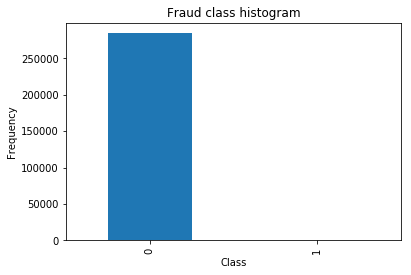

In [3]:
count_classes = pd.value_counts(df['Class'], sort = True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Fraud class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")

In [4]:
number_records_fraud = len(df[df.Class == 1])
fraud_indices = np.array(df[df.Class == 1].index)
print(number_records_fraud)

492


Normalize the amount column and add it as new column to data-frame, drop the old column 'Amount' and 'Time'

In [5]:
df['normAmount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1,1))
df = df.drop(['Time','Amount'],axis=1)
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,normAmount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403


Build a classification model on the data, for demonstration purpose we are using Logistic Regression classifier. with out much parameter tuning lets apply the following steps
        separate the features, target 
        split the data into train and test
        fit the train data
        predict on test data
        observe the recall score
    

0.62
Confusion matrix, without normalization


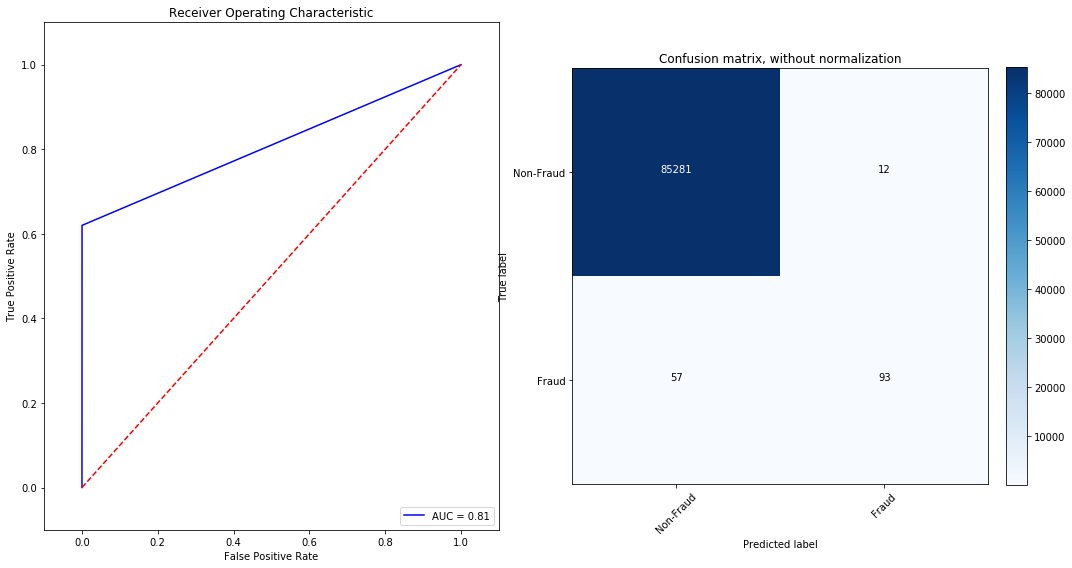

In [6]:
y_unbalanced = df['Class']
X_unbalanced = df.drop(['Class'], axis=1)


X_ub_train, X_ub_test, y_ub_train, y_ub_test = train_test_split(X_unbalanced,y_unbalanced, test_size=0.3)

# played with different C values and sticked with .1 for demonstration purpose

lrclf_ub = LogisticRegression(penalty='l1', C=0.1)


lrclf_ub.fit(X_ub_train, y_ub_train)

y_ub_predict = lrclf_ub.predict(X_ub_test)

print(recall_score(y_ub_test, y_ub_predict))

cnf_ub_matrix = confusion_matrix(y_ub_test, y_ub_predict)

plt.figure(1, figsize=(15,8))
plt.subplot(121)
plot_roc_curve(y_ub_test, y_ub_predict)

plt.subplot(122)
plot_confusion_matrix(cnf_ub_matrix, classes=['Non-Fraud','Fraud'],
                      title='Confusion matrix, without normalization')

plt.show()

Plot the ROC curve

Let's undersample the data, as there are 492 records of fraud, lets randomly pick 492 records of non-fradulent records and fit the model with new data. there are other methods of doing balancing methodolgies like SMOTE( which does combination of under and over sampling) 

In [7]:
# Picking the indices of the normal classes
normal_indices = df[df.Class == 0].index

# Out of the indices we picked, randomly select "x" number (number_records_fraud)
random_normal_indices = np.random.choice(normal_indices, number_records_fraud, replace = False)

random_normal_indices = np.array(random_normal_indices)
undersampleIndices = np.concatenate([random_normal_indices,fraud_indices])

# print(undersampleIndices)

under_sampled_data = df.iloc[undersampleIndices,:]

print(under_sampled_data.shape)

(984, 30)


In [8]:
y_us = under_sampled_data['Class']
X_us = under_sampled_data.drop(['Class'], axis=1)

X_us.head()


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,normAmount
58544,1.210477,-0.221134,-0.261920,-0.230975,0.198673,0.198393,-0.036606,-0.024491,0.242190,-0.215023,...,0.100576,-0.147072,-0.517652,-0.143802,-1.265440,0.307922,1.011320,-0.076274,0.000828,-0.063768
1363,-0.629947,1.241011,1.290353,0.111235,-0.441852,-1.128839,0.429558,0.242220,-0.760241,-0.712779,...,-0.140103,-0.060370,-0.319637,0.147350,0.711308,-0.689641,-0.038185,-0.006292,0.103116,-0.328241
206353,1.765662,-0.794697,-0.548170,0.182711,-0.624822,-0.027562,-0.596968,0.103264,0.791356,0.172832,...,0.076357,0.291409,0.660530,0.124794,0.820970,-0.407881,0.584345,-0.065018,-0.032257,0.110549
42763,0.508566,-1.565965,0.491658,0.624973,-0.676783,1.761306,-0.610791,0.439902,-0.608499,0.338849,...,0.000761,0.073832,0.336275,-0.207624,-0.934187,0.121180,-0.129830,0.095455,0.075304,0.926158
252261,1.581389,-1.970693,0.059951,-0.119292,-2.027480,-0.137369,-1.238874,0.046221,0.560226,0.676874,...,-0.069952,-0.011094,0.021432,0.091618,-0.101056,-0.769973,0.607576,-0.021870,0.012900,0.714260


Hyper tuning for parameters, One of the parameter for Logistic Regression is 'C'

In [9]:
# Lets use LogisticRegressionCV to determine the parameters
# using default solver lbfgs and penalty is l2
# cross fold validation is StratifiedKFold

c_range=[0.01,0.1,1,10,100]
lrcv = LogisticRegressionCV(Cs=c_range, scoring ='roc_auc', solver ='liblinear', penalty='l1', cv= 15, random_state=89, max_iter= 10000)

lrcv.fit(X_us, y_us)

# print("scores :"+lrcv.scores_)
best_C = lrcv.C_[0]
print(best_C)



0.1


Build a new classifier with the undersampled data, using the same solver and penalty used during tuning

0.929577464789
Confusion matrix, without normalization


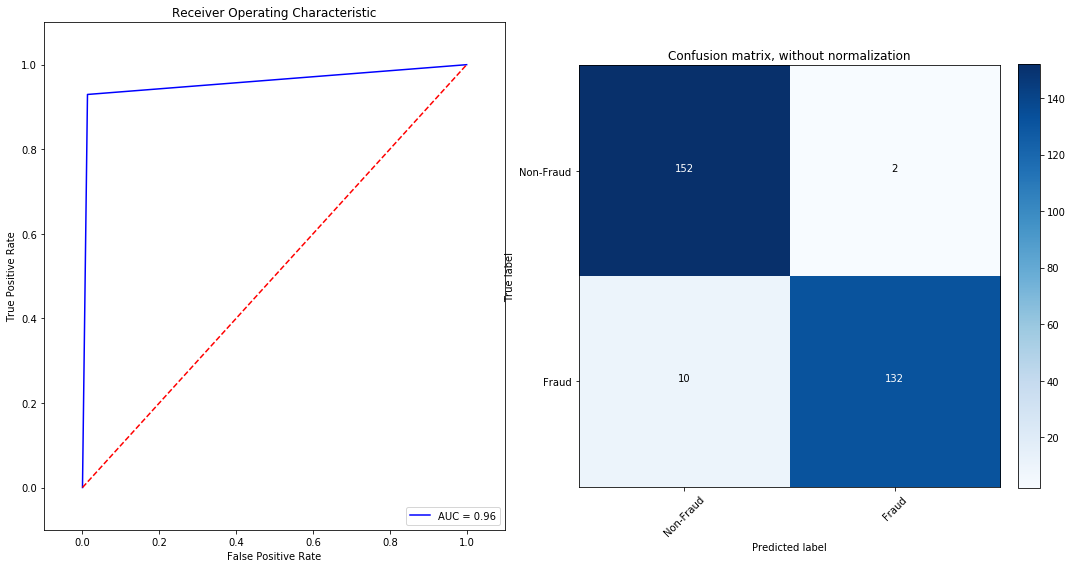

In [10]:

#split the undersample and pass it to new classifier
X_us_train, X_us_test, y_us_train, y_us_test = train_test_split(X_us, y_us, test_size=0.3)

#Create a new Logistic Regression classifier with penality and C

us_lrclf = LogisticRegression(penalty='l1',solver='liblinear', C=best_C)

us_lrclf.fit(X_us_train, y_us_train)

y_us_predict = us_lrclf.predict(X_us_test)

# print(accuracy_score(y_us_test, y_us_predict))


print(recall_score(y_us_test, y_us_predict))

cnf_us_matrix = confusion_matrix(y_us_test, y_us_predict)

plt.figure(1, figsize=(15,8))
plt.subplot(121)
plot_roc_curve(y_us_test, y_us_predict)

plt.subplot(122)
plot_confusion_matrix(cnf_us_matrix, classes=['Non-Fraud','Fraud'],
                      title='Confusion matrix, without normalization')

plt.show()



The recall score improved from near 60's to  near 90's when data set is un-skewed (undersampled)

Plot the ROC curve on the new classifier.

0.884057971014
Confusion matrix, without normalization


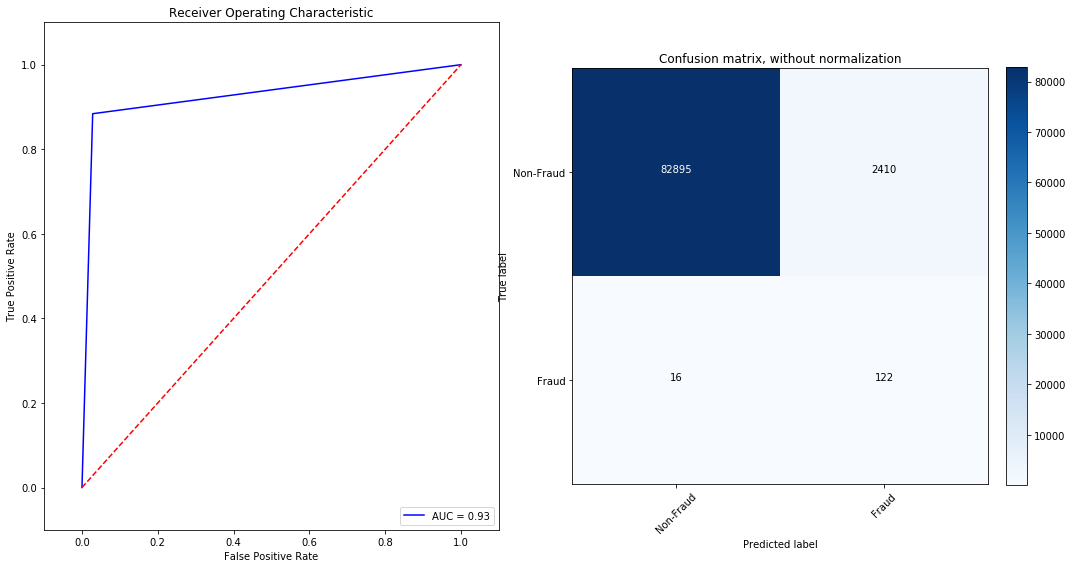

In [11]:
# Lets apply on the whole data set with previously trained classifier

y = df['Class']
X = df.drop(['Class'], axis=1)


X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3)

# us_lrclf.fit(X_train, y_train)

y_predict = us_lrclf.predict(X_test)
print(recall_score(y_test, y_predict))

cnf_matrix = confusion_matrix(y_test, y_predict)

plt.figure(1, figsize=(15,8))
plt.subplot(121)
plot_roc_curve(y_test, y_predict)

plt.subplot(122)
plot_confusion_matrix(cnf_matrix, classes=['Non-Fraud','Fraud'],
                      title='Confusion matrix, without normalization')

plt.show()



By applying the classifier trained on un-skewed data set to whole data set the recall_score is dropped by 3 to 4 points. A decent classifier though

Let's see whether the following transaction is fraud or not

In [12]:
test_record = [[0.20168,0.49748,1.37391,0.57140,-0.630657,-0.53965,-0.07627,-0.91710,0.27000,-0.48028,-0.51253,0.68090,0.08992,-0.157405,-0.58881,-0.47790,0.22538,-0.66868,-0.02359,-0.22230,0.71896,-0.17187,-0.16620,0.77647,0.81846,0.44254,0.14275,0.21923,0.1254368]]

y_test_record_class = us_lrclf.predict(test_record)
y_test_record_proba = us_lrclf.predict_proba(test_record)

print(y_test_record_class)
print(y_test_record_proba)


[0]
[[ 0.85217682  0.14782318]]


## SGDClassifier

Let's  apply a different classifier Stochastic Gradient Descent Classifier on the balanced data-set and observe the ROC

0.929577464789
Confusion matrix, without normalization


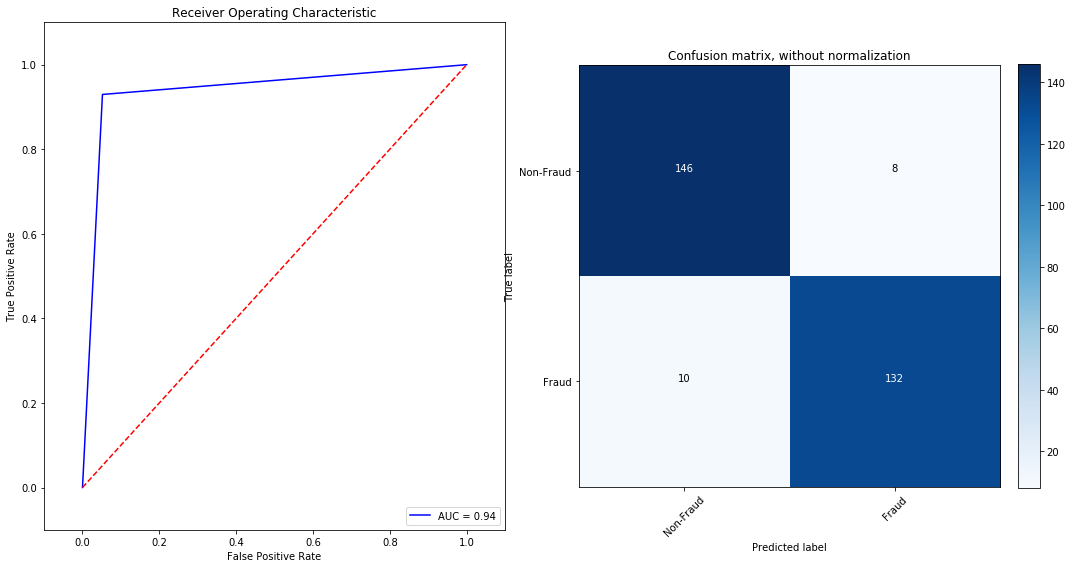

In [13]:
us_sgdclf = SGDClassifier(loss='modified_huber', penalty='l1', alpha=0.0001, l1_ratio=1, max_iter=10000)

us_sgdclf.fit(X_us_train,y_us_train)

y_us_sgd = us_sgdclf.predict(X_us_test)

cnf_us_sgd_matrix = confusion_matrix(y_us_test, y_us_sgd)

print(recall_score(y_us_test,y_us_sgd))

plt.figure(1, figsize=(15,8))
plt.subplot(121)
plot_roc_curve(y_us_test, y_us_sgd)

plt.subplot(122)
plot_confusion_matrix(cnf_us_sgd_matrix, classes=['Non-Fraud','Fraud'],
                      title='Confusion matrix, without normalization')

plt.show()

Apply the above built model on the entire data set and observe the ROC

0.913043478261
Confusion matrix, without normalization


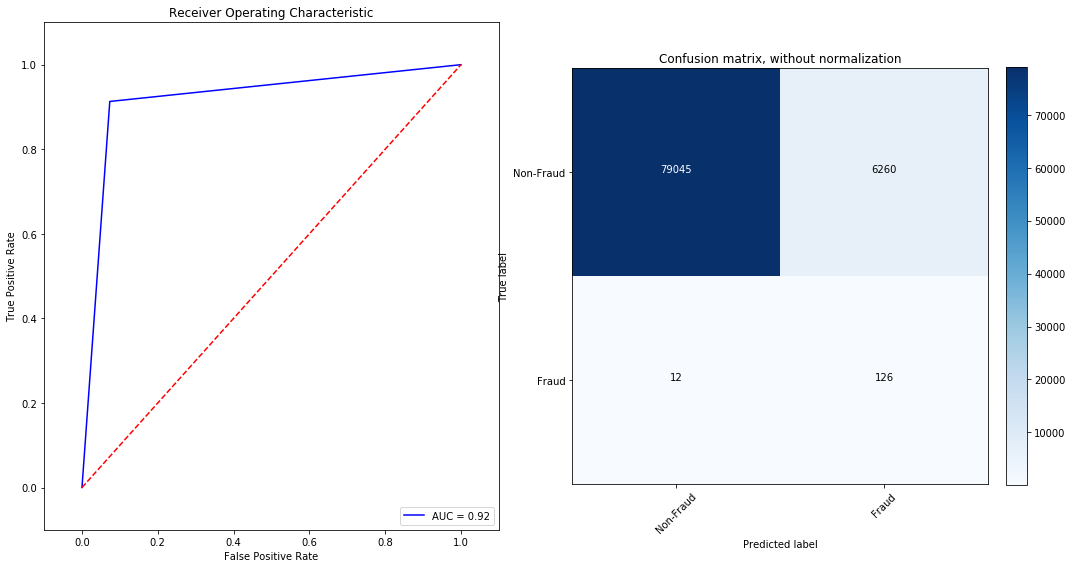

In [14]:
y_test_sgd = us_sgdclf.predict(X_test)

print(recall_score(y_test,y_test_sgd))

#print data-frame to observer false positives

cnf_sgd_matrix = confusion_matrix(y_test, y_test_sgd)

plt.figure(1, figsize=(15,8))
plt.subplot(121)
plot_roc_curve(y_test, y_test_sgd)

plt.subplot(122)
plot_confusion_matrix(cnf_sgd_matrix, classes=['Non-Fraud','Fraud'],
                      title='Confusion matrix, without normalization')

plt.show()


## Isolation Forest


In [15]:
# separate anomaly from normal

normal = df[df['Class']==0]
anomaly = df[df['Class'] ==1]

train, normal_test,_,_ = train_test_split(normal, normal, test_size=.4, random_state = 42)


normal_cv, normal_test,_,_ = train_test_split(normal_test, normal_test, test_size =.5, random_state = 42)

# break the anomaly into half
anomaly_cv, anomaly_test, _,_ = train_test_split(anomaly, anomaly, test_size=.5, random_state = 42)

# append the anomalies to cv and test
cv = normal_cv.append(anomaly_cv).sample(frac=1).reset_index(drop=True)
test = normal_test.append(anomaly_test).sample(frac=1).reset_index(drop=True)

print(train.shape)
print(cv.shape)
print(test.shape)


(170589, 30)
(57109, 30)
(57109, 30)


In [16]:
from sklearn.ensemble import IsolationForest

us_ifclf = IsolationForest(n_estimators=40, max_samples= train.shape[0],bootstrap=True, random_state=42, max_features= 28, n_jobs=4)

us_ifclf.fit(train.drop('Class', axis=1).values)

#print the mean values of decision function values for cross validation scores
non_anomolus = us_ifclf.decision_function(cv[cv['Class'] == 0].drop('Class', axis=1).values)
anomolus = us_ifclf.decision_function(cv[cv['Class'] == 1].drop('Class', axis=1).values)

#Mean values
print(non_anomolus.mean())
print(anomolus.mean())

 

0.153019253963
-0.0509512996118


Seems like the mean of normal class is at 0.15 while anomaly class is around -0.04, need to figure out the epsilon (optimal distance of distribution to consider a record as anomaly)<br> Let's plot the distribution

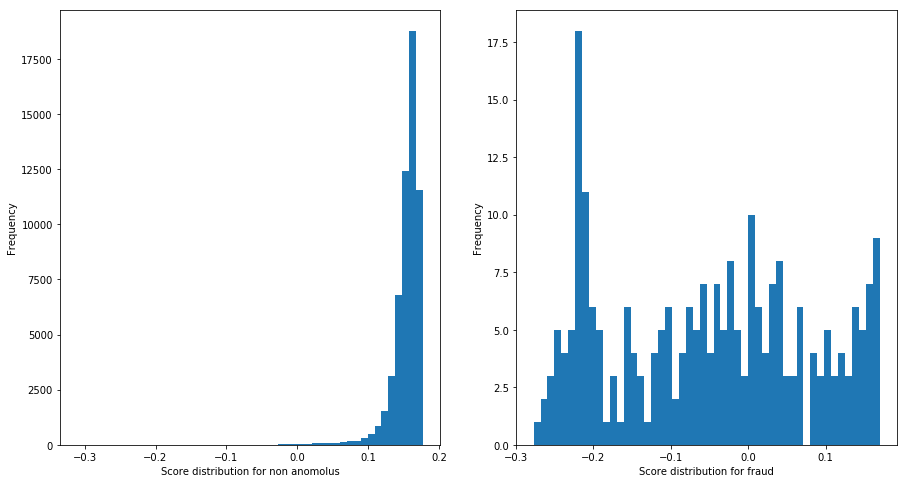

In [17]:
plt.figure(1,figsize=(15,8))

plt.subplot(121)
plt.xlabel('Score distribution for non anomolus')
plt.ylabel('Frequency')
plt.hist(non_anomolus, bins=50)

plt.subplot(122)
plt.xlabel('Score distribution for fraud')
plt.ylabel('Frequency')
plt.hist(anomolus, bins=50)

plt.show()

In [18]:
#commented code that gives the best epsilon value

thresholds = np.linspace(-.2, .2, 200)
y_scores = us_ifclf.decision_function(cv.drop('Class', axis=1).values)
scores = []
for threshold in thresholds:
    y_hat = (y_scores < threshold).astype(int)
    scores.append([recall_score(y_pred=y_hat, y_true=cv['Class'].values),
                  precision_score(y_pred=y_hat, y_true=cv['Class'].values),
                  fbeta_score(y_pred=y_hat, y_true=cv['Class'].values, beta=2)])

scores = np.array(scores)
print(scores[:, 2].max(), scores[:, 2].argmax())
#threshold value for which fbeta score is max
print(thresholds[scores[:, 2].argmax()])

0.58651026393 104
0.00904522613065


In [19]:
epsilon = 0.03

y_hat_test = (us_ifclf.decision_function(test.drop('Class', axis=1).values) < epsilon).astype(int)

print(recall_score(test['Class'].values, y_hat_test))
pd.DataFrame(confusion_matrix(test['Class'].values, y_hat_test))

0.731707317073


,0,1
0,56529,334
1,66,180


0.904471544715
Confusion matrix, without normalization


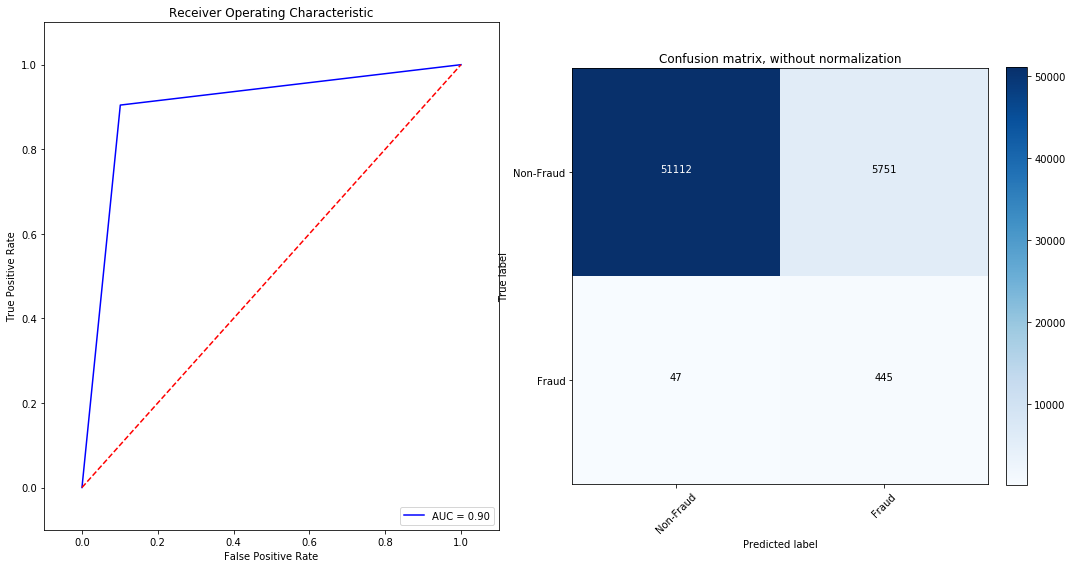

In [20]:
# Apply train test split on normal and append the anomaly to test size and find the recall score

X_normal,X_test,_,_ = train_test_split(normal,normal, test_size=.2, random_state= 42)

directtest = X_test.append(anomaly).sample(frac=1).reset_index(drop=True)


# directly fit an isolation forest

newifclf = IsolationForest(n_estimators=50, max_samples= train.shape[0],bootstrap=True, random_state=42, max_features= 28)

newifclf.fit(X_normal)

newifclf.predict(X_normal)

y_pred = newifclf.predict(directtest)

new_y_pred = np.empty(y_pred.shape)

for i in range(len(y_pred)):
    if(y_pred[i] == -1):
        new_y_pred[i]=1
    else:
        new_y_pred[i]=0
        
new_y_test = directtest['Class'].values

print(recall_score(new_y_test,new_y_pred))

cnf_isf_matrix = confusion_matrix(new_y_test,new_y_pred)

#print dataframe

plt.figure(1, figsize=(15,8))
plt.subplot(121)
plot_roc_curve(new_y_test, new_y_pred)

plt.subplot(122)
plot_confusion_matrix(cnf_isf_matrix, classes=['Non-Fraud','Fraud'],
                      title='Confusion matrix, without normalization')

plt.show()